# Figures in paper and appendix

Here you'll find the code used to generate all plots in the final writeup. This notebook essentially loads a cache file with all relevant metrics pre-computed and only focuses on fine-tuning the visualizations themselves

# Setup, loading and plotting functions

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import deepdish as dd
import matplotlib.patches as mpatches

In [2]:
def load(args):
    args['image_suffix'] = args.get("image_suffix", "")
    cache_path = f"{args['save-dir']}/{args['experiment']}/{args['expid']}/cache"
    cache_file = f"{cache_path}/{args['visualization']}{args['image_suffix']}.h5"
    if os.path.isfile(cache_file):
        metrics = dd.io.load(cache_file)
        if args['visualization'] == 'performance':
            if type(metrics) == dict:
                performance = metrics['performance']
                steps = list(performance.keys())
            else:
                steps, performance = metrics
            return steps, performance
        else:
            if type(metrics) == dict:
                empirical = metrics['empirical']
                theoretical = metrics.get('theoretical', None)
                layers = list(empirical.keys())
                steps = list(empirical[layers[0]].keys())
            else:
                if len(metrics) == 3:
                    steps, empirical, theoretical = metrics
                else:
                    steps, empirical = metrics
                    theoretical = None
            return steps, empirical, theoretical
    else:
        print(f"You do not have a cache file @ {cache_file}. Run the plot in the command line first")
        return (None, None, None)

In [3]:
def plot(steps, empirical, theoretical, axes, 
    layer_list=None, layer_wise=False, subset=0, normalize=False, legend=False,
    color_idx_adj=0, theory_color="w", layer_filter=lambda x: True, **kwargs,
):
    
    if empirical is not None or theoretical is not None:
        # get layer list
        empirical_or_theoretical = empirical if theoretical is None else theoretical
        layers = list(empirical_or_theoretical.keys())
        if "conv" in layers[0]:
            layers = sorted(layers, key=lambda l: int(l.split("conv")[1]))
        if layer_list is not None:
            layers = [layers[i] for i in layer_list]
        
    # plot empirical
    if empirical is not None:
        layers = [l for l in layers if layer_filter(l)]
        for layer in layers:
            norm = list(empirical[layer].values())
            if layer_wise:
                norm = [np.sum(i) for i in norm]
            if subset > 0:
                norm = [i[0:subset] for i in norm]
            if normalize:
                norm = norm / norm[0]
            color = plt.cm.tab20(color_idx_adj)
            if "conv" in layer:
                color_idx = int(layer.split("conv")[1]) - 1 + color_idx_adj
                color = plt.cm.tab20(color_idx)
            axes.plot(
                steps,
                norm,
                color=color,
                label=layer,
                **kwargs
            )
    if legend:
        plt.legend()
            
    # plot theoretical
    if theoretical is not None:
        for layer in layers:
            norm = list(theoretical[layer].values())
            if layer_wise:
                norm = [np.sum(i) for i in norm]
            if subset > 0:
                norm = [i[0:subset] for i in norm]
            if normalize:
                norm = norm[0]
            axes.plot(
                steps,
                norm,
                color=theory_color,
                ls='--',
                lw=2,
                #alpha=0.5
            )

In [4]:
def plot_performance(steps, performance, axes):
    color = "k"
    plot_steps = []
    for step in steps:
        if "train_loss" in performance[step].keys():
            plot_steps.append(step)
    axes.plot(
        plot_steps, [performance[s]["train_loss"] for s in plot_steps], color=color,
    )
    axes.plot(
        plot_steps,
        [performance[s]["test_loss"] for s in plot_steps],
        color=color,
        alpha=0.5,
    )
    axes.tick_params(axis="y", labelcolor=color)
    axes.set_ylabel(f"loss")

    axes2 = axes.twinx()
    color = "tab:blue"
    axes2.plot(
        plot_steps, [performance[s]["accuracy1"] for s in plot_steps], color=color,
    )
    axes2.plot(
        plot_steps,
        [performance[s]["accuracy5"] for s in plot_steps],
        color=color,
        alpha=0.5,
    )
    axes2.tick_params(axis="y", labelcolor=color)
    axes2.set_ylabel(f"accuracy")

    # axes labels and title
    axes.set_xlabel("train step")
    axes.title.set_text(f"Performance for model over training time")

In [5]:
def plot_network(steps, empirical, axes, layer_list=None, layer_wise=False, square=False):
    if layer_list == None:
        layers = list(empirical.keys())
    else:
        layers = [list(empirical.keys())[i] for i in layer_list]

    handles = []
    layers = [l for l in layers if "conv" in l]
    for idx, layer in enumerate(layers):
        norm = list(empirical[layer].values())
        if square:
            norm = [i ** 2 for i in norm]
        if layer_wise:
            norm = [np.sum(i) for i in norm]
        axes.plot(
            steps, norm, color=plt.cm.tab20(idx), label=layer, lw=2, alpha=0.5,
        )
        handles += [mpatches.Patch(color=plt.cm.tab20(idx), label=layer)]

# Figure 1.a
(Note: this figure has too much detail and likely needs to be generated in an off-notebook script)

In [ ]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
    "visualization": "network",
    "subset": 1000,
    "image-suffix": "_subset",
}
wds = ["0", "1en4"]#, "5en4", "1en3"]
wds = ["1en4"]#, "5en4", "1en3"]

nrows = 1
ncols = len(wds)
fig, axs = plt.subplots(nrows, ncols, figsize=(15*ncols, 15*nrows), sharex='col', sharey=True) #sharex='col'
for j, wd_str in enumerate(wds):
    lr_str = "1en1"
    lr = float(lr_str.replace("n", "-"))
    wd = float(wd_str.replace("n", "-"))
    # plot data
    ax = axs
    args['expid'] = f"vgg16-bn_bs256_lr{lr_str}_wd{wd_str}"

    steps, empirical, _ = load(args)
    plot_network(steps, empirical, ax)
    #steps, empirical = load(args)
    #if steps is not None:
    #    steps = [lr * float(step) for step in steps]
    #plot(steps, empirical, None, ax, layer_wise=False, 
    #     layer_filter=lambda x: "conv" in x, 
    #     **{"lw":2, "alpha":0.5}
    #)
    
    # tick params and axis labels
    if j == 0:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
plt.show()
plt.savefig("sgd_network_subset.pdf")

# Figure 1.b

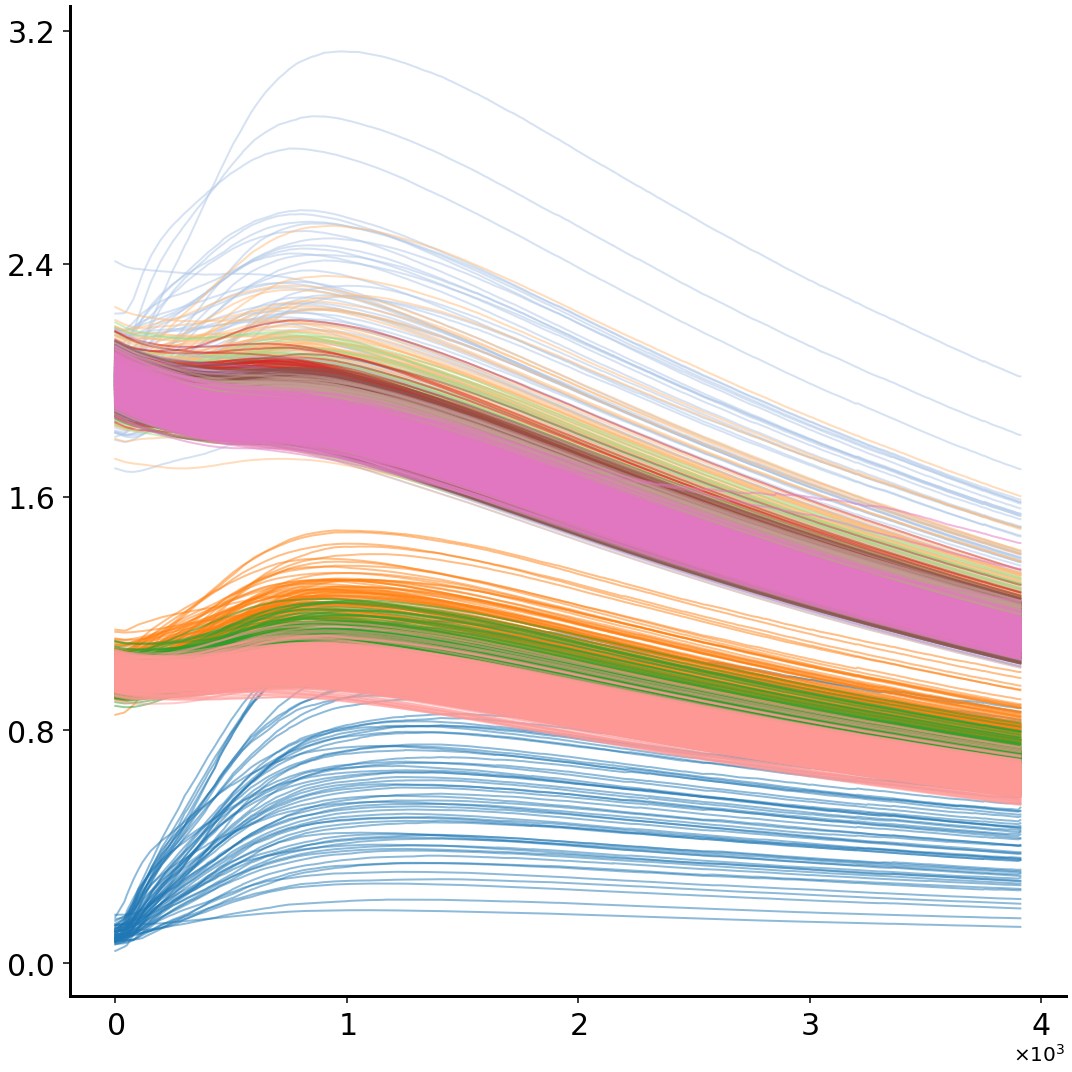

In [6]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
    "visualization": "scale"
}
wds = ["0", "1en4"]#, "5en4", "1en3"]
wds = ["1en4"]
nrows = 1
ncols = len(wds)
fig, axs = plt.subplots(nrows, ncols, figsize=(15*ncols, 15*nrows), sharex='col')#, sharey=True) #sharex='col'
for j, wd_str in enumerate(wds):
    lr_str = "1en1"
    lr = float(lr_str.replace("n", "-"))
    wd = float(wd_str.replace("n", "-"))
    # plot data
    ax = axs
    args['expid'] = f"vgg16-bn_bs256_lr{lr_str}_wd{wd_str}"

    steps, empirical, theoretical = load(args)
    if steps is not None:
        steps = [lr * float(step) for step in steps]
    plot(steps, empirical, None, ax, layer_wise=False, **{"lw":2, "alpha":0.5})


    # tick params and axis labels
    if j == 0:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("scale_neuronwise_tinyimagenet.pdf")

# Figure 5

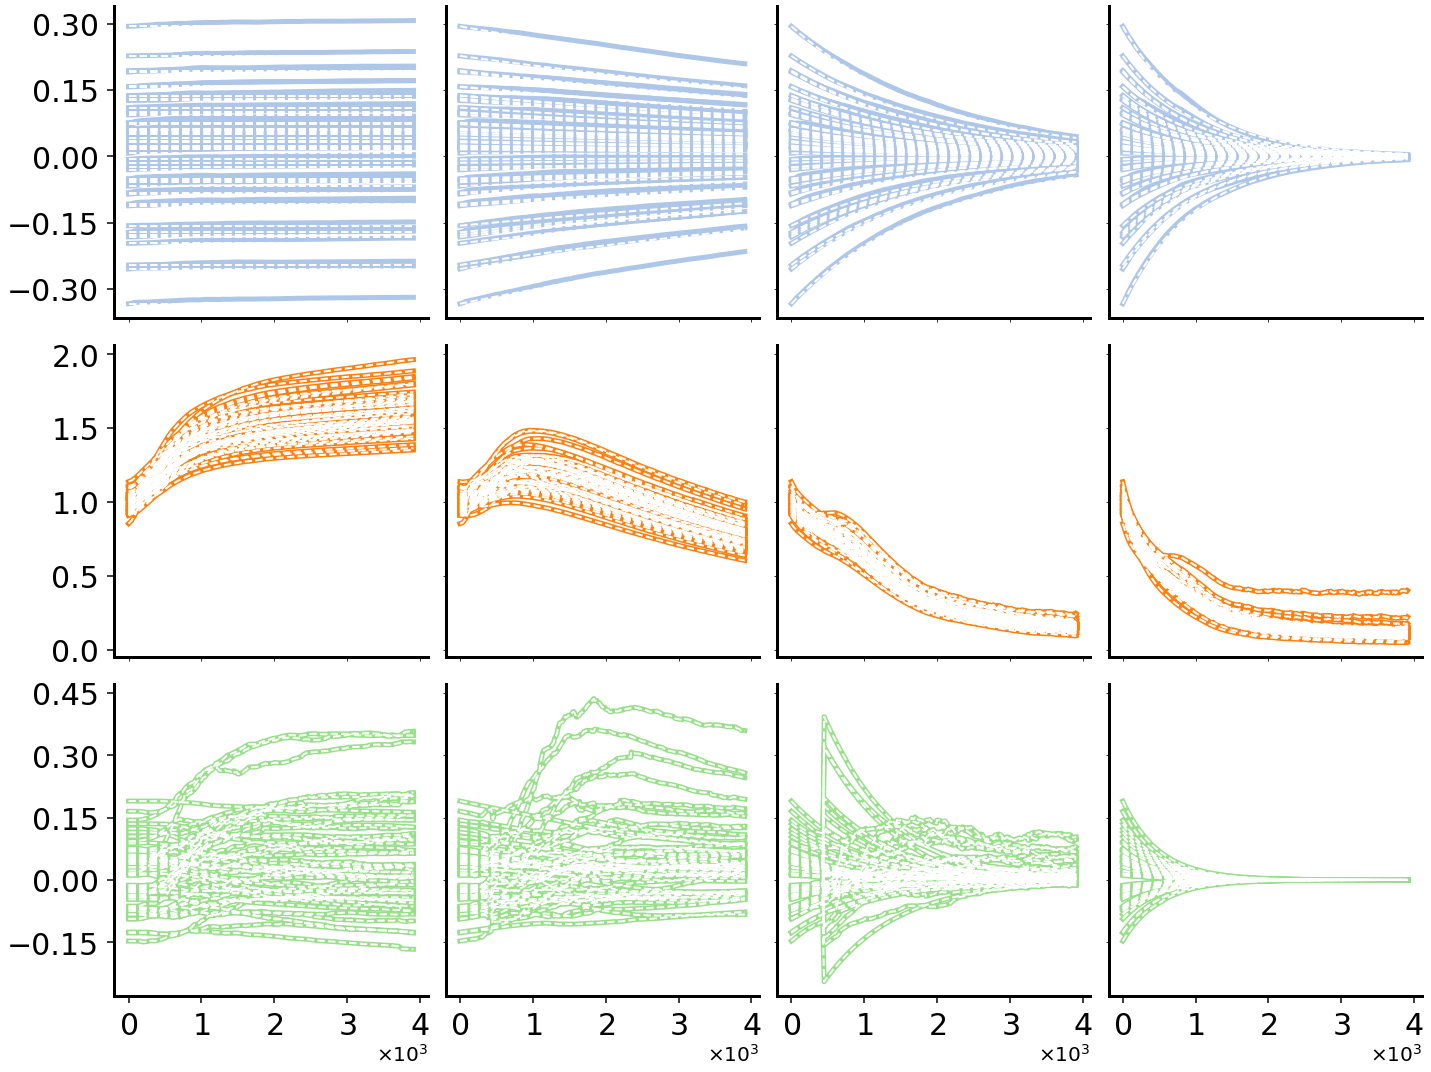

In [40]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
}
nrows = 3
ncols = 4
layers = [0,2,5]
colors = [1,0,-1]
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey='row') #sharex='col'
for j, wd_str in enumerate(["0", "1en4", "5en4", "1en3"]):
    for i, (viz, layer) in enumerate(zip(["translation", "scale", "inversion"], layers)):
        lr_str = "1en1"
        lr = float(lr_str.replace("n", "-"))
        wd = float(wd_str.replace("n", "-"))
        # plot data
        ax = axs[i, j]
        bn = "-bn" if viz == "scale" else ""
        args['expid'] = f"vgg16{bn}_bs256_lr{lr_str}_wd{wd_str}"
        args['visualization'] = f"{viz}"
        
        steps, empirical, theoretical = load(args)
        if steps is not None:
            steps = [lr * float(step) for step in steps]
        plot(steps, empirical, theoretical, ax, layer_wise=False, layer_list=[layer], 
             subset=60, color_idx_adj=colors[i],theory_color="k", **{"lw": 5})


        # tick params and axis labels
        
        if j == 0:
            ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if i == nrows -1:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)
            
        # boundary
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("allviz-neuronwise.pdf")

# Figure 6

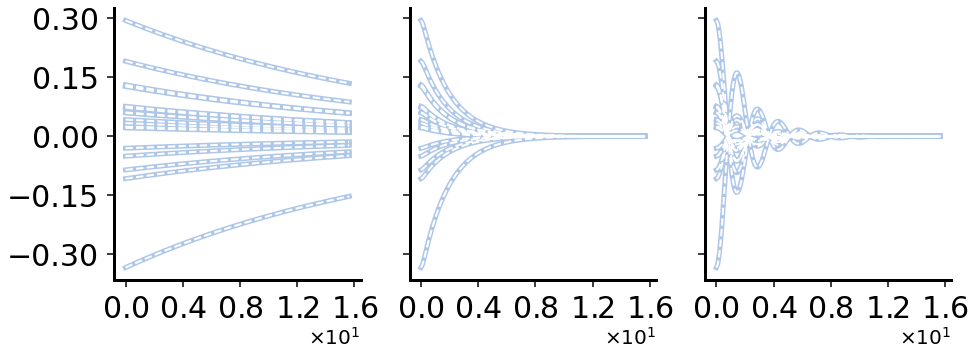

<Figure size 432x288 with 0 Axes>

In [76]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16",
    "visualization": "translation",
}
nrows = 1
ncols = 3

lr_str = "0.01"
for gamma_str in ["0"]:
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey='col') #sharex='col'
    
    for i, beta_str in enumerate(["0.0", "0.9", "0.99"]):
        for j, wd_str in enumerate(["0.05"]):
            lr = float(lr_str.replace("n", "-"))
            wd = float(wd_str.replace("n", "-"))
            # plot data
            ax = axs[i]
            args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"

            steps, empirical, theoretical = load(args)
            if steps is not None:
                steps = [lr * float(step) for step in steps]
            plot(steps, empirical, theoretical, ax, layer_wise=False, subset=20, 
                 color_idx_adj=1, theory_color="k", **{"lw": 5})

            # tick params and axis labels
            
            if i == 0:
                ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            else:
                ax.tick_params(axis="y", bottom=False, top=False,
                           labelbottom=False, left=True, right=False,
                           labelleft=False,direction='out',length=7,width=1.5,pad=8)
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)

            # boundary
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            for dir in ["top", "bottom", "right", "left"]:
                ax.spines[dir].set_linewidth(3)
        
    plt.show()
plt.savefig("translation_momentum.pdf")

# Figure 8

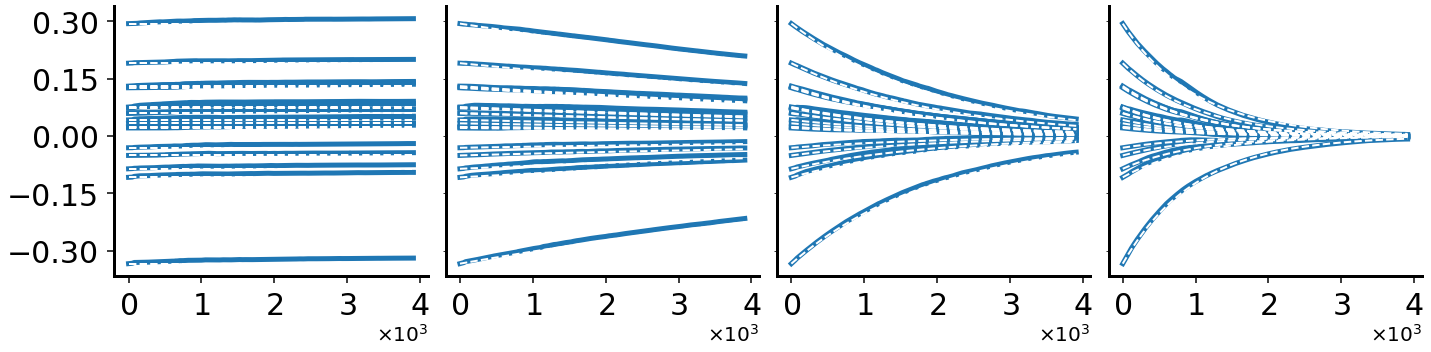

In [36]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
    "visualization": "translation"
}
nrows = 1
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
for j, wd_str in enumerate(["0", "1en4", "5en4", "1en3"]):
    lr_str = "1en1"
    lr = float(lr_str.replace("n", "-"))
    wd = float(wd_str.replace("n", "-"))
    # plot data
    ax = axs[j]
    args['expid'] = f"vgg16_bs256_lr{lr_str}_wd{wd_str}"

    steps, empirical, theoretical = load(args)
    if steps is not None:
        steps = [lr * float(step) for step in steps]
    plot(steps, empirical, theoretical, ax, layer_wise=False, subset=20, **{"lw": 5})


    # tick params and axis labels
    if j == 0:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("translation_tinyimagenet.pdf")

# Figure 9

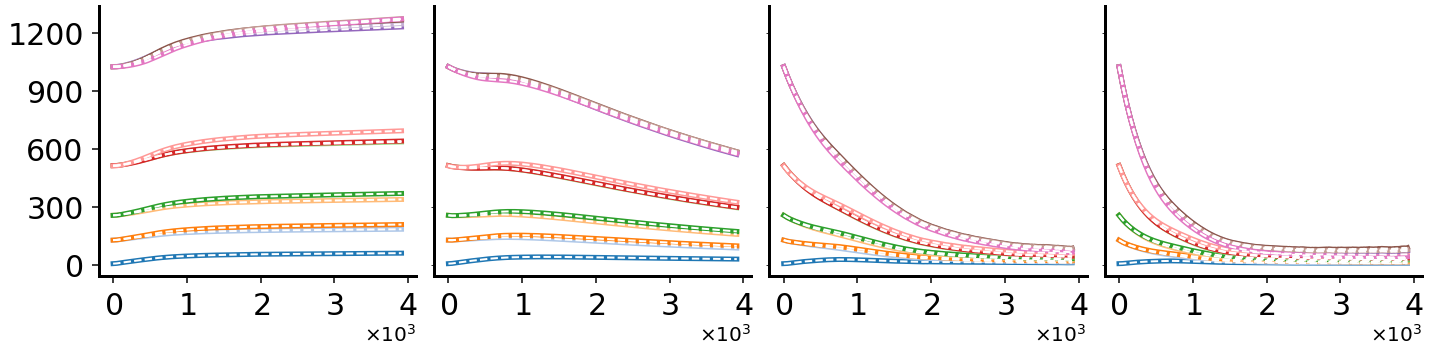

In [32]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
    "visualization": "scale"
}
nrows = 1
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
for j, wd_str in enumerate(["0", "1en4", "5en4", "1en3"]):
    lr_str = "1en1"
    lr = float(lr_str.replace("n", "-"))
    wd = float(wd_str.replace("n", "-"))
    # plot data
    ax = axs[j]
    args['expid'] = f"vgg16-bn_bs256_lr{lr_str}_wd{wd_str}"

    steps, empirical, theoretical = load(args)
    if steps is not None:
        steps = [lr * float(step) for step in steps]
    plot(steps, empirical, theoretical, ax, layer_wise=True, **{"lw": 5})


    # tick params and axis labels
    if j == 0:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("scale_tinyimagenet.pdf")

# Figure 10

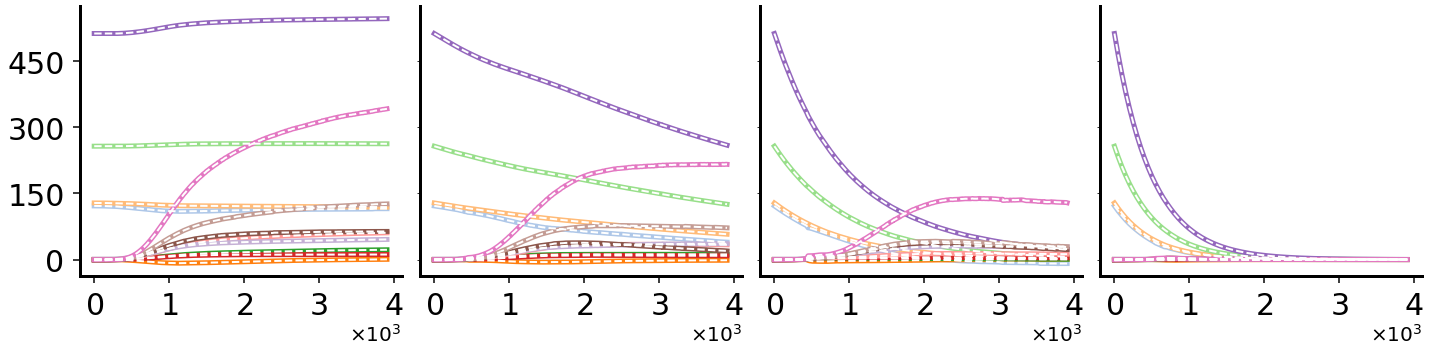

In [33]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
    "visualization": "inversion"
}
nrows = 1
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
for j, wd_str in enumerate(["0", "1en4", "5en4", "1en3"]):
    lr_str = "1en1"
    lr = float(lr_str.replace("n", "-"))
    wd = float(wd_str.replace("n", "-"))
    # plot data
    ax = axs[j]
    args['expid'] = f"vgg16_bs256_lr{lr_str}_wd{wd_str}"

    steps, empirical, theoretical = load(args)
    if steps is not None:
        steps = [lr * float(step) for step in steps]
    plot(steps, empirical, theoretical, ax, layer_wise=True, **{"lw": 5})


    # tick params and axis labels
    if j == 0:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("inversion_tinyimagenet.pdf")

# Figure 11

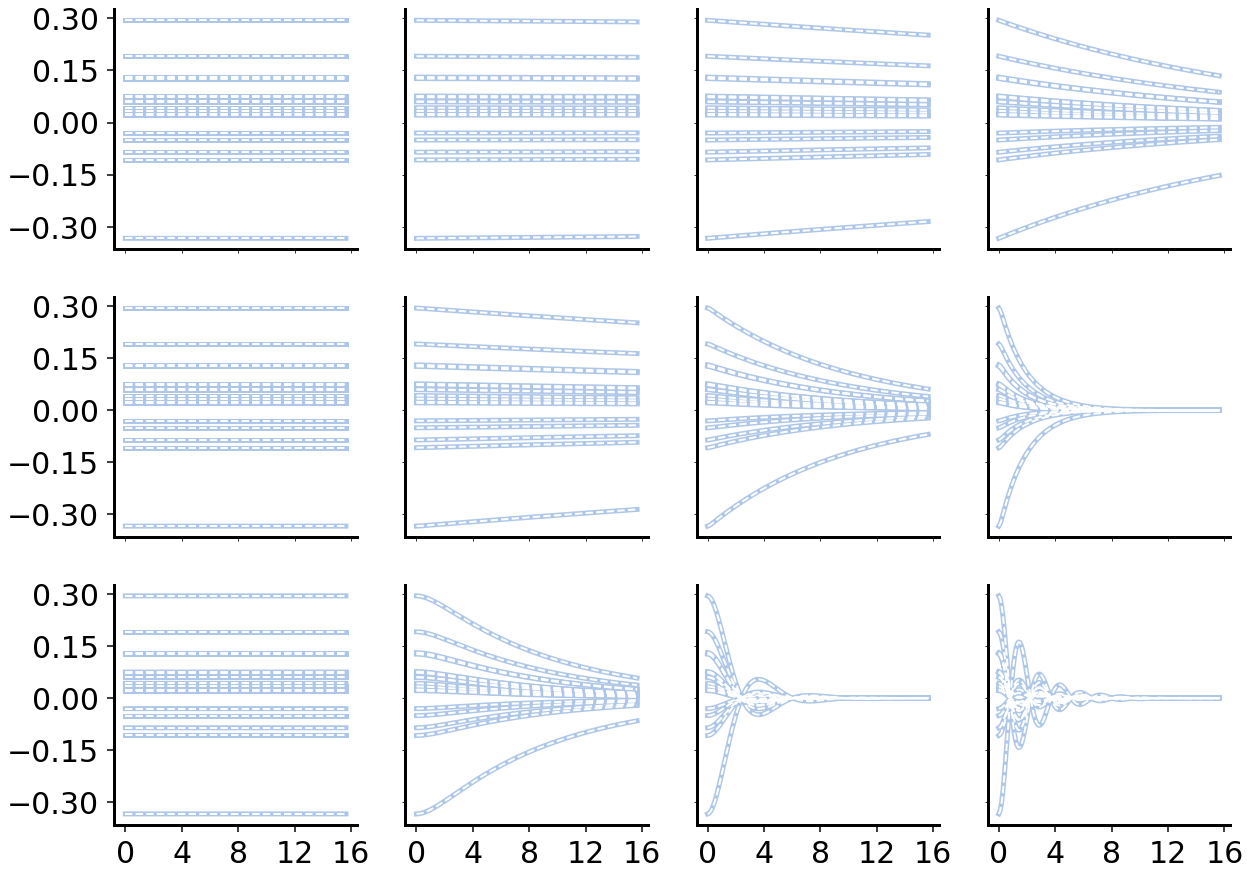

In [75]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16",
    "visualization": "translation",
}
nrows = 3
ncols = 4

lr_str = "0.01"
for gamma_str in ["0"]:
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
    
    for i, beta_str in enumerate(["0.0", "0.9", "0.99"]):
        for j, wd_str in enumerate(["0.0", "0.001", "0.01", "0.05"]):
        #for j, wd_str in enumerate(["0.001", "0.01", "0.05"]):
            lr = float(lr_str.replace("n", "-"))
            wd = float(wd_str.replace("n", "-"))
            # plot data
            ax = axs[i,j]
            args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"

            steps, empirical, theoretical = load(args)
            if steps is not None:
                steps = [lr * float(step) for step in steps]
            plot(steps, empirical, theoretical, ax, layer_wise=False, subset=20, 
                 color_idx_adj=1, theory_color="k", **{"lw": 5,})

            # tick params and axis labels
            ax.set_title("")
            ax.set_ylabel("")
            #if j == 0:
            #    ax.set_ylabel(f"beta {beta_str}", fontsize=30)
            #if i == 0:
            #    ax.set_title(f"wd {wd_str}", fontsize=30)
            
            if j == 0:
                ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            if i == nrows-1:
                ax.tick_params(axis="x", which="both", bottom=True, top=False,
                               labelbottom=True, left=True, right=False,
                               labelleft=True,direction='out',length=7,width=1.5,pad=8,
                               labelsize=30)
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
                ax.xaxis.offsetText.set_fontsize(20)

            # boundary
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            for dir in ["top", "bottom", "right", "left"]:
                ax.spines[dir].set_linewidth(3)
        
    #fig.suptitle(f"{args['visualization']}, gamma {gamma_str}", fontsize=30)
    #plt.show()
plt.savefig("translation_momentum.pdf")

# Figure 12

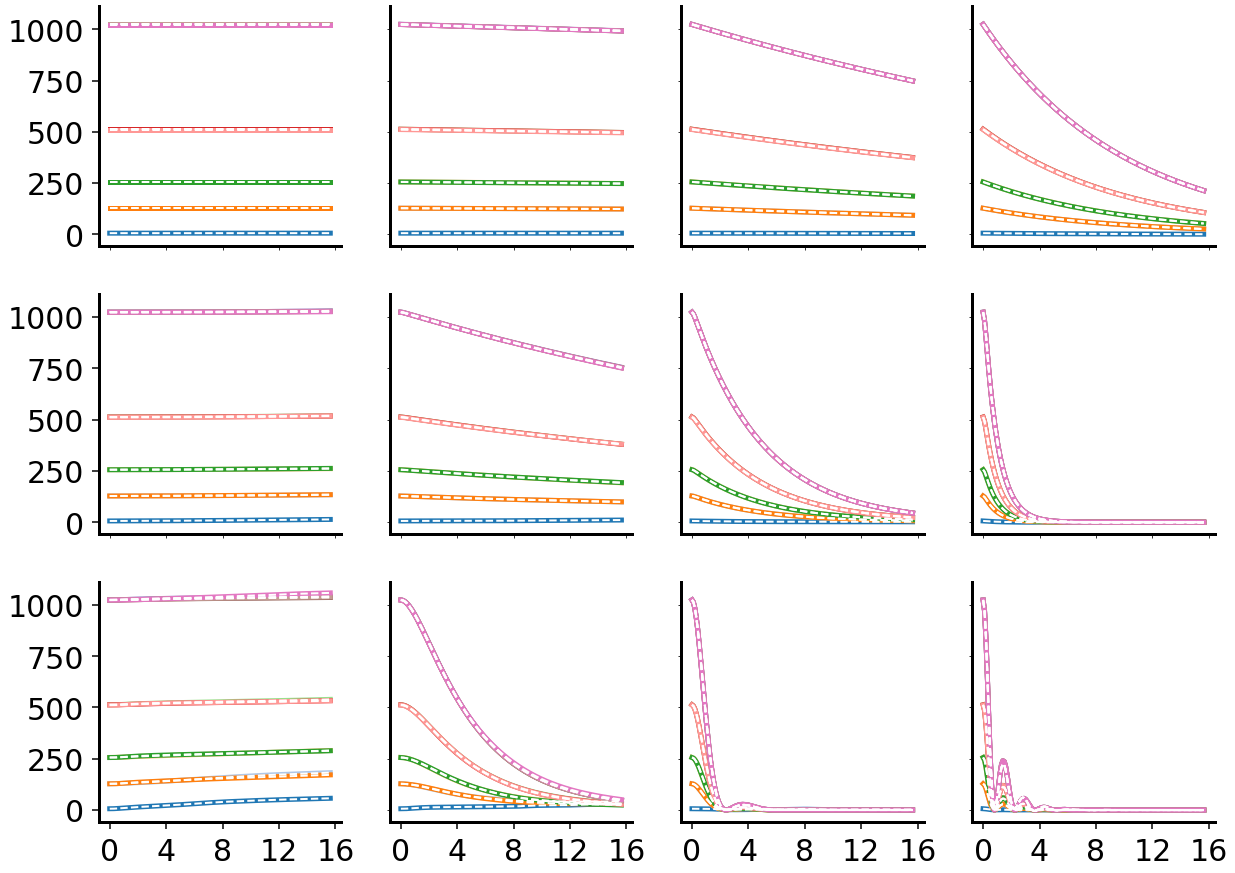

In [77]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16-bn",
    "visualization": "scale",
}
nrows = 3
ncols = 4

lr_str = "0.01"
for gamma_str in ["0"]:
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
    
    for i, beta_str in enumerate(["0.0", "0.9", "0.99"]):
        for j, wd_str in enumerate(["0.0", "0.001", "0.01", "0.05"]):
        #for j, wd_str in enumerate(["0.001", "0.01", "0.05"]):
            lr = float(lr_str.replace("n", "-"))
            wd = float(wd_str.replace("n", "-"))
            # plot data
            ax = axs[i,j]
            args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"

            steps, empirical, theoretical = load(args)
            if steps is not None:
                steps = [lr * float(step) for step in steps]
            plot(steps, empirical, theoretical, ax, layer_wise=True, **{"lw": 5,})

            # tick params and axis labels
            ax.set_title("")
            ax.set_ylabel("")
            #if j == 0:
            #    ax.set_ylabel(f"beta {beta_str}", fontsize=30)
            #if i == 0:
            #    ax.set_title(f"wd {wd_str}", fontsize=30)
            
            if j == 0:
                ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            if i == nrows-1:
                ax.tick_params(axis="x", which="both", bottom=True, top=False,
                               labelbottom=True, left=True, right=False,
                               labelleft=True,direction='out',length=7,width=1.5,pad=8,
                               labelsize=30)
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
                ax.xaxis.offsetText.set_fontsize(20)

            # boundary
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            for dir in ["top", "bottom", "right", "left"]:
                ax.spines[dir].set_linewidth(3)
        
    #fig.suptitle(f"{args['visualization']}, gamma {gamma_str}", fontsize=30)
#plt.show()
plt.savefig("scale_momentum.pdf")

# Figure 13

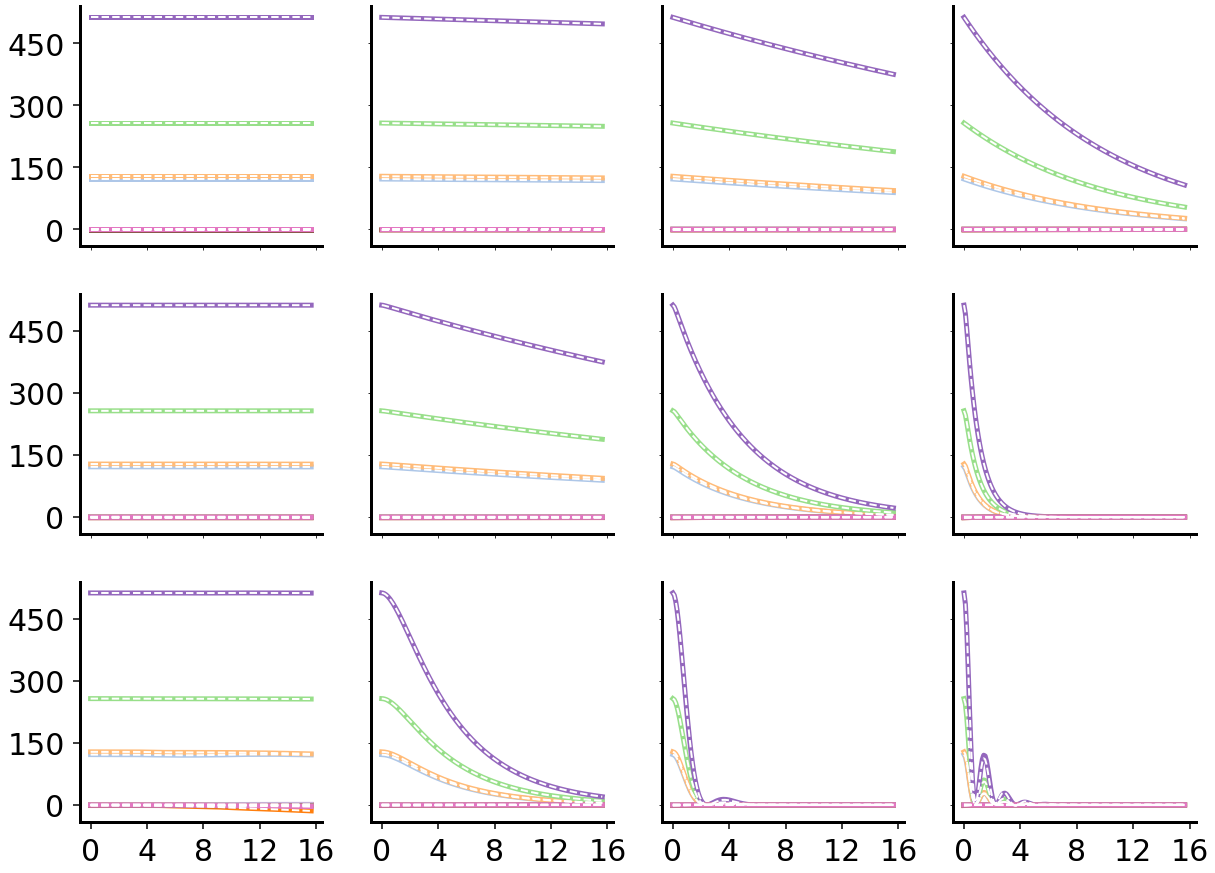

In [74]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16",
    "visualization": "inversion",
}
nrows = 3
ncols = 4

lr_str = "0.01"
for gamma_str in ["0"]:
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharex='col', sharey=True) #sharex='col'
    
    for i, beta_str in enumerate(["0.0", "0.9", "0.99"]):
        for j, wd_str in enumerate(["0.0", "0.001", "0.01", "0.05"]):
        #for j, wd_str in enumerate(["0.001", "0.01", "0.05"]):
            lr = float(lr_str.replace("n", "-"))
            wd = float(wd_str.replace("n", "-"))
            # plot data
            ax = axs[i,j]
            args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"

            steps, empirical, theoretical = load(args)
            if steps is not None:
                steps = [lr * float(step) for step in steps]
            plot(steps, empirical, theoretical, ax, layer_wise=True, theory_color="k", **{"lw": 5,})

            # tick params and axis labels
            ax.set_title("")
            ax.set_ylabel("")
            #if j == 0:
            #    ax.set_ylabel(f"beta {beta_str}", fontsize=30)
            #if i == 0:
            #    ax.set_title(f"wd {wd_str}", fontsize=30)
            
            if j == 0:
                ax.tick_params(axis="y", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
                ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            if i == nrows-1:
                ax.tick_params(axis="x", which="both", bottom=True, top=False,
                               labelbottom=True, left=True, right=False,
                               labelleft=True,direction='out',length=7,width=1.5,pad=8,
                               labelsize=30)
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
                ax.xaxis.offsetText.set_fontsize(20)

            # boundary
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False) 
            for dir in ["top", "bottom", "right", "left"]:
                ax.spines[dir].set_linewidth(3)
        
    #fig.suptitle(f"{args['visualization']}, gamma {gamma_str}", fontsize=30)
#plt.show()
plt.savefig("inversion_momentum.pdf")

# Figure 14

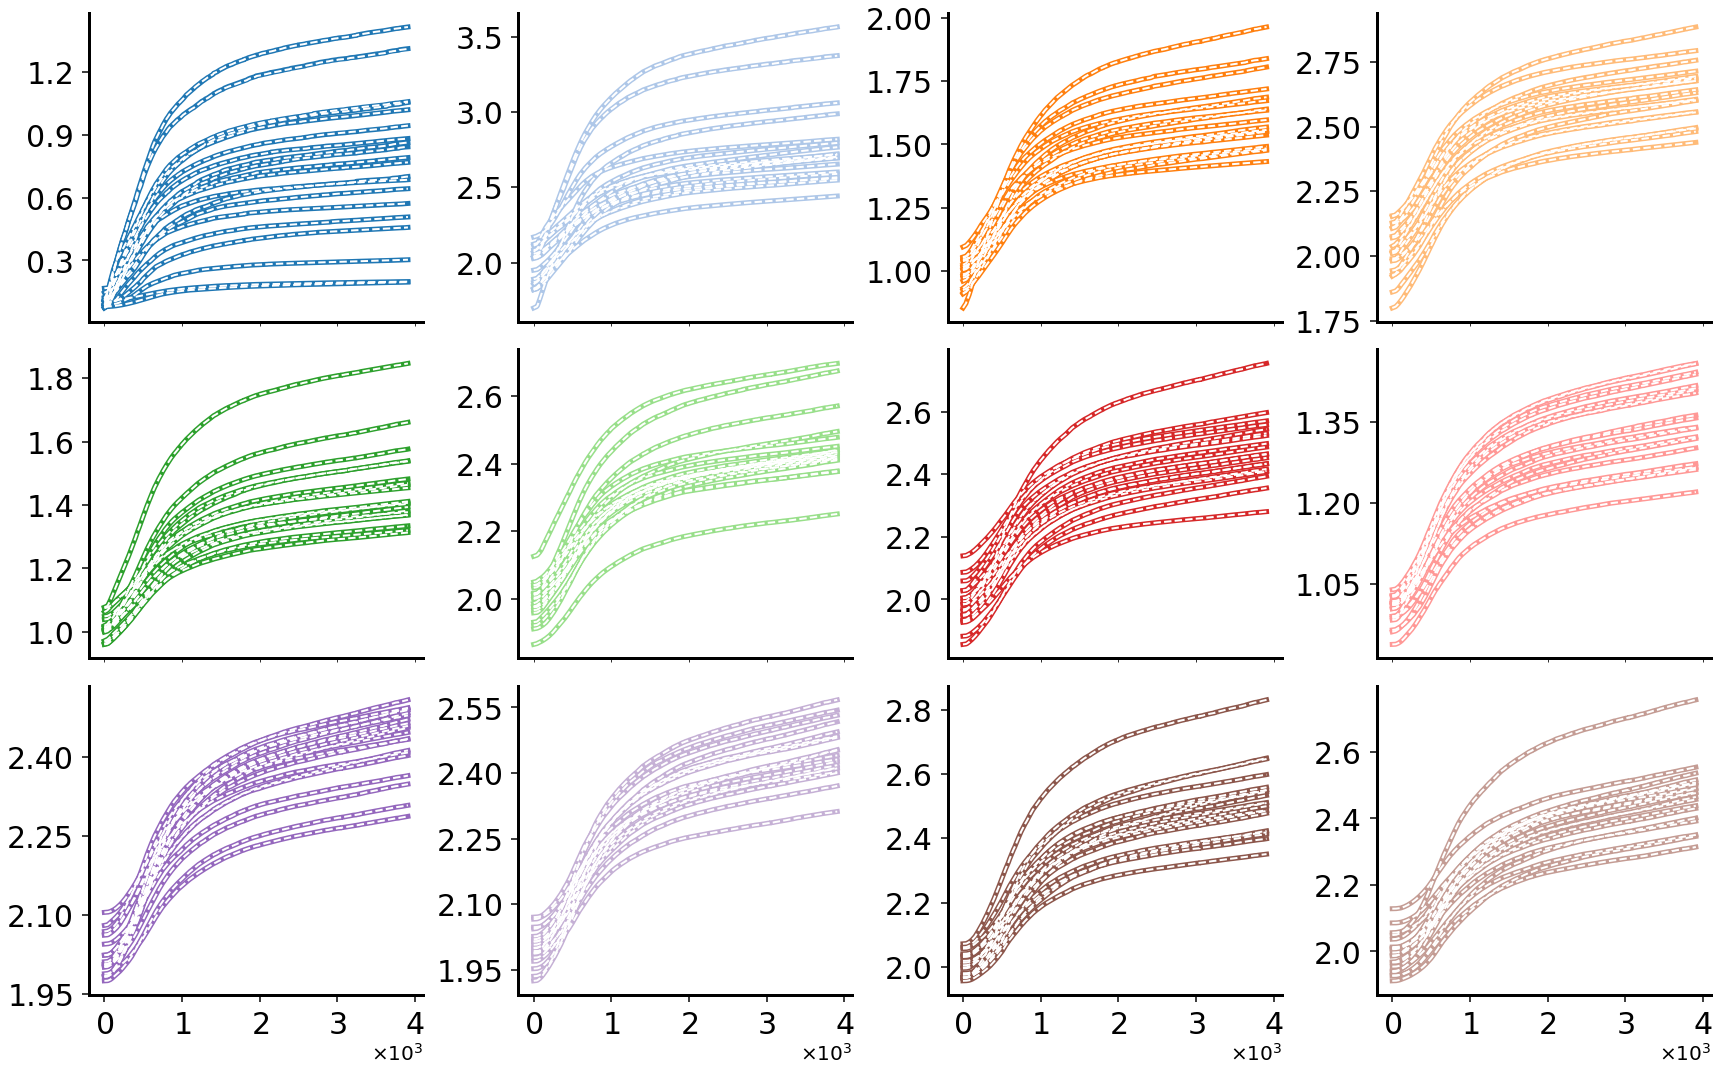

In [38]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
}
nrows = 3
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col')#, sharey=True) #sharex='col'
for i, layer in enumerate(range(12)):
    for j, viz in enumerate(["scale"]):
        lr_str = "1en1"
        wd_str = "0"
        lr = float(lr_str.replace("n", "-"))
        wd = float(wd_str.replace("n", "-"))
        # plot data
        ax = axs[i//ncols + j*3, i%ncols]
        bn = "-bn" if viz == "scale" else ""
        args['expid'] = f"vgg16{bn}_bs256_lr{lr_str}_wd{wd_str}"
        args['visualization'] = f"{viz}"
        
        steps, empirical, theoretical = load(args)
        if steps is not None:
            steps = [lr * float(step) for step in steps]
        plot(steps, empirical, theoretical, ax, layer_wise=False, layer_list=[layer], 
             subset=20, color_idx_adj=0 if viz =="scale" else -1, theory_color="k", **{"lw": 5})


        # tick params and axis labels
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if i > 7:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)
            
        # boundary
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("scale_tinyimagenet_layerwise.pdf")

# Figure 15

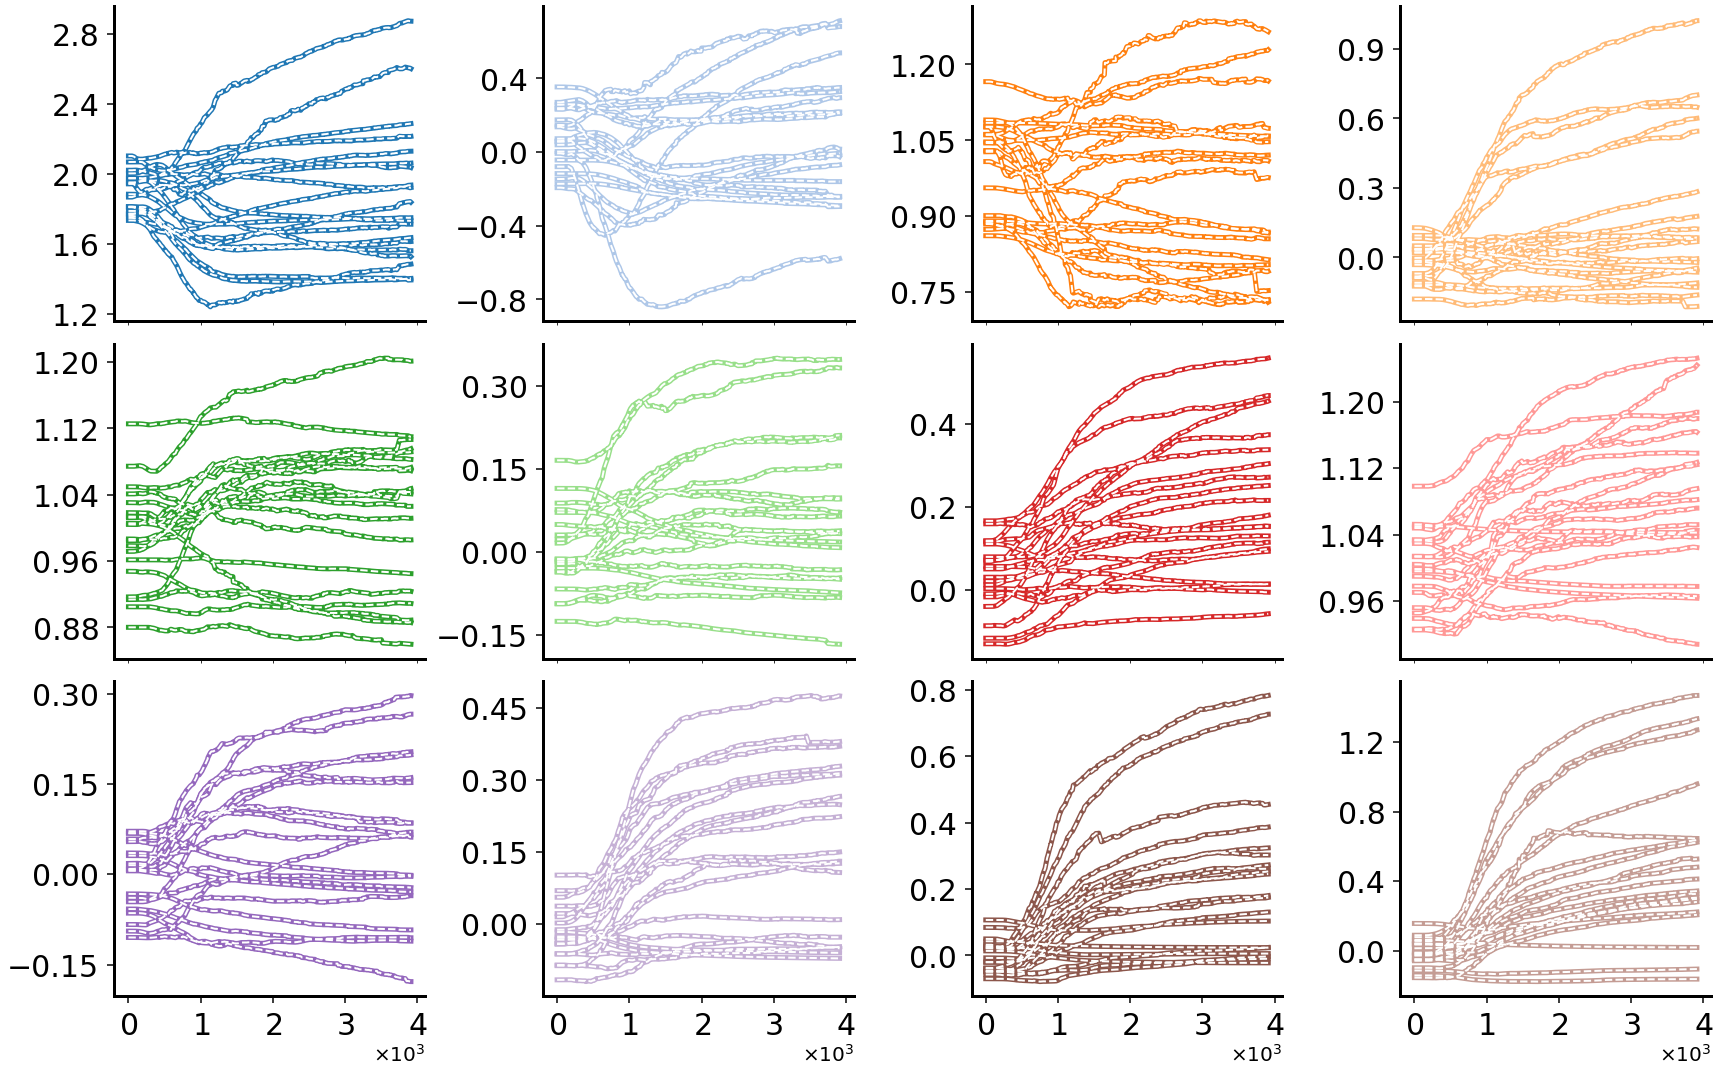

In [39]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics/gs_jvr-pt-tpu",
    "experiment": "tinyimagenet",
}
nrows = 3
ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col')#, sharey='row') #sharex='col'
for i, layer in enumerate(range(12)):
    for j, viz in enumerate(["inversion"]):
        lr_str = "1en1"
        wd_str = "0"
        lr = float(lr_str.replace("n", "-"))
        wd = float(wd_str.replace("n", "-"))
        # plot data
        ax = axs[i//ncols + j*3, i%ncols]
        bn = "-bn" if viz == "scale" else ""
        args['expid'] = f"vgg16{bn}_bs256_lr{lr_str}_wd{wd_str}"
        args['visualization'] = f"{viz}"
        
        steps, empirical, theoretical = load(args)
        if steps is not None:
            steps = [lr * float(step) for step in steps]
        plot(steps, empirical, theoretical, ax, layer_wise=False, layer_list=[layer], 
             subset=20, color_idx_adj=0 if viz =="scale" else -1, theory_color="k", **{"lw": 5})


        # tick params and axis labels
        
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if i > 7:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)
            
        # boundary
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
            
plt.tight_layout()
plt.savefig("inversion_tinyimagenet_layerwise.pdf")

# Figure 16

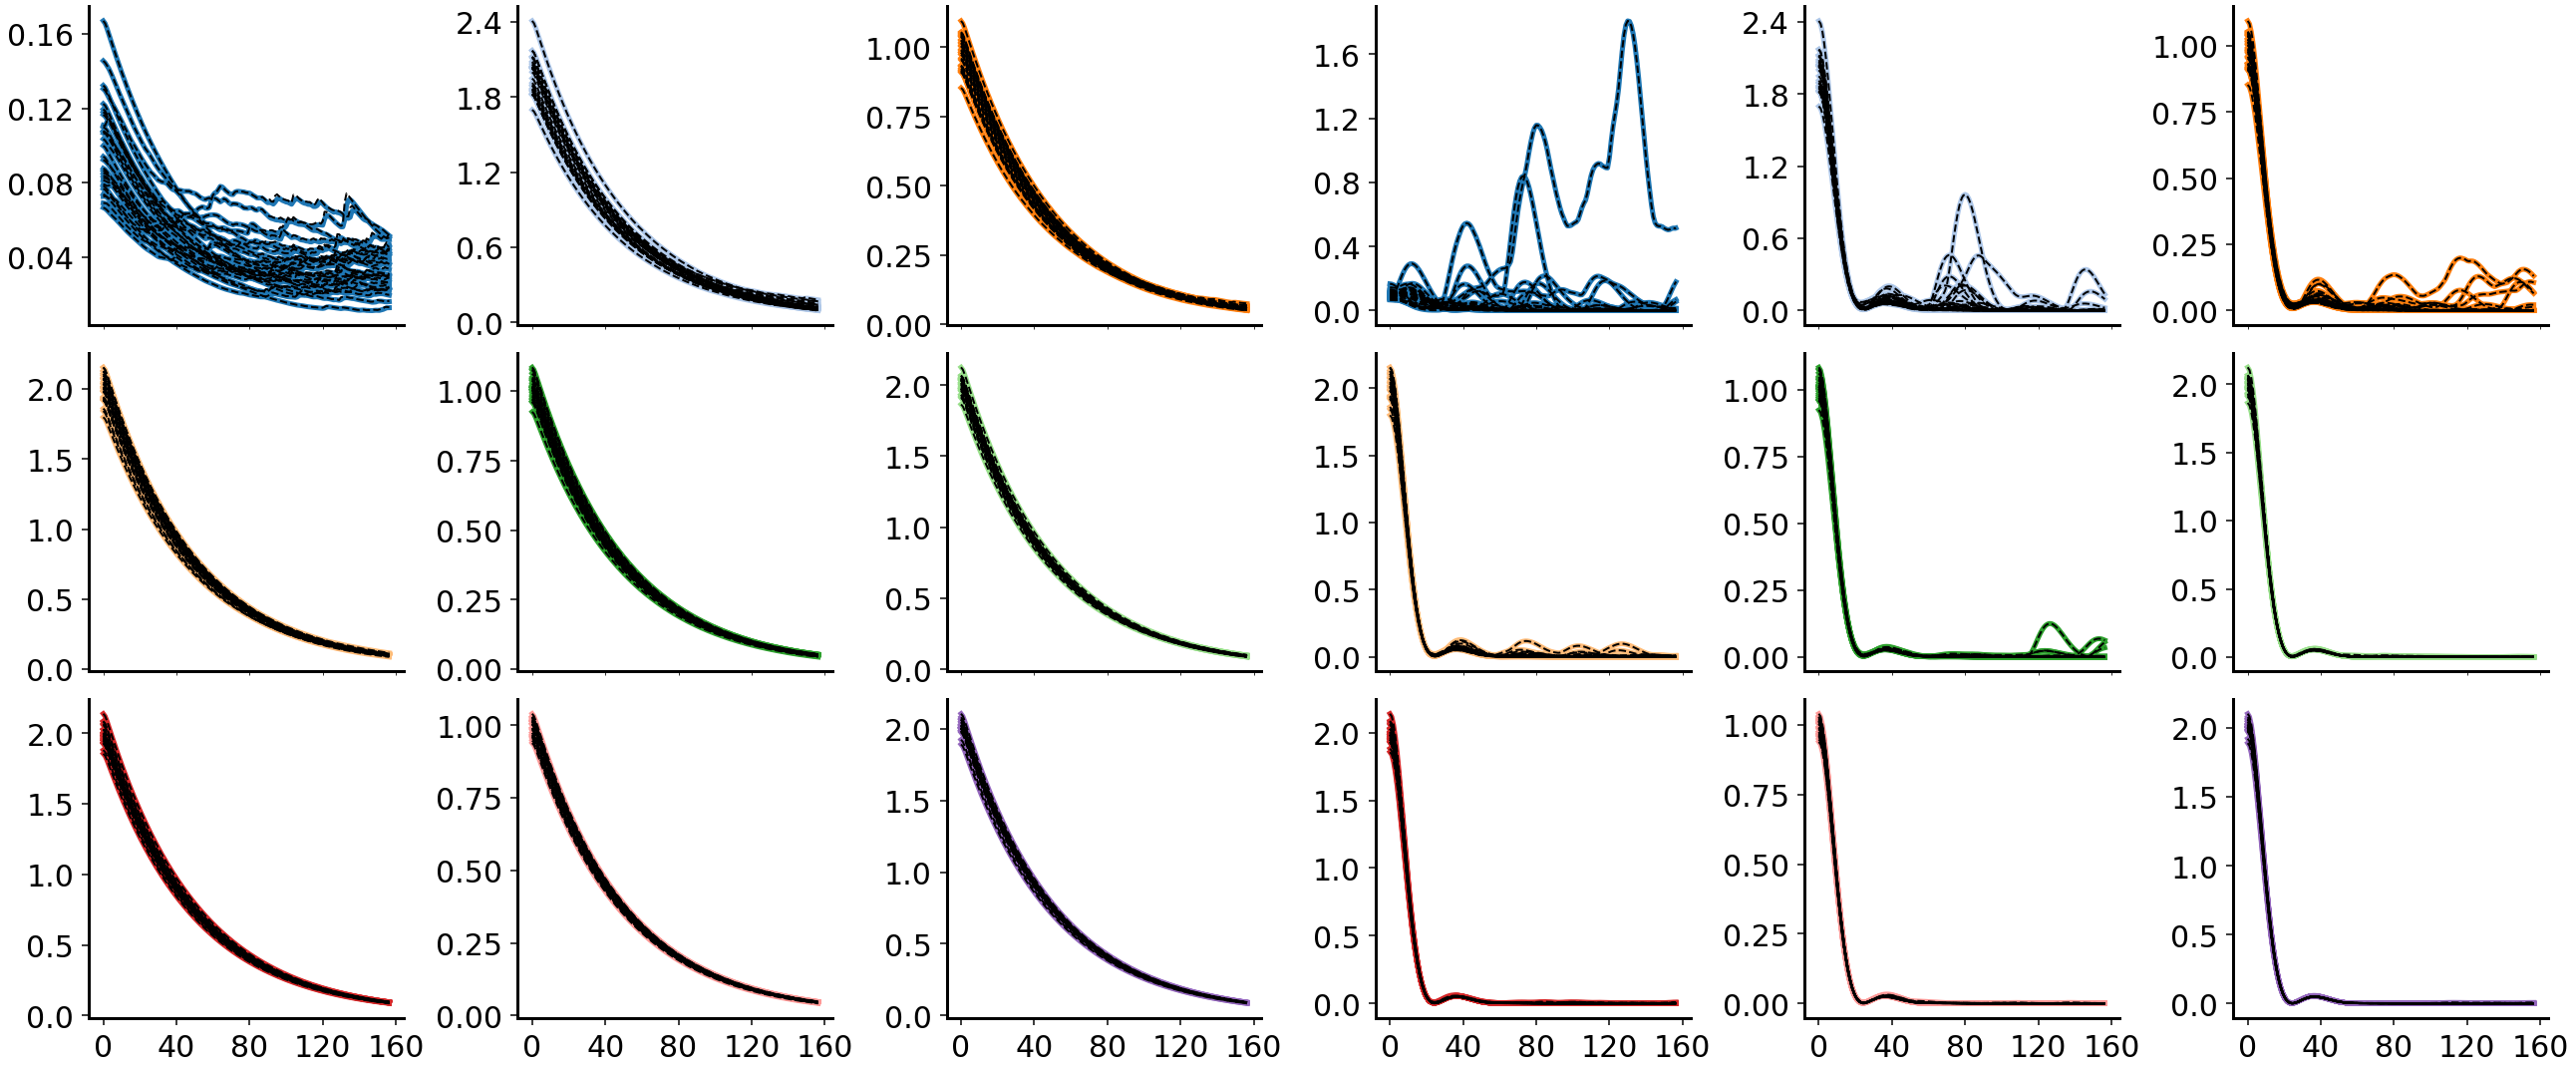

In [7]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16-bn",
    "visualization": "scale",
}
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col')#, sharey='row') #sharex='col'
for i, layer in enumerate(range(9)):
    for j, beta_str in enumerate(["0.9", "0.99"]):
        lr_str = "0.01"
        wd_str = "0.01"
        gamma_str = "0"
        # plot data
        ax = axs[i//(ncols//2), i%(ncols//2) + j*nrows]
        args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"
        
        steps, empirical, theoretical = load(args)
        if steps is not None:
            steps = [lr * float(step) for step in steps]
        plot(steps, empirical, theoretical, ax, layer_wise=False, layer_list=[layer], 
             subset=30, color_idx_adj=0 if args["visualization"] == "scale" else -1, theory_color="k", **{"lw":5})


        # tick params and axis labels
        
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if i > 5:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)
            
        # boundary
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
        
            
plt.tight_layout()
plt.savefig("over-under-damped-momentum-scale.pdf")

# Figure 17

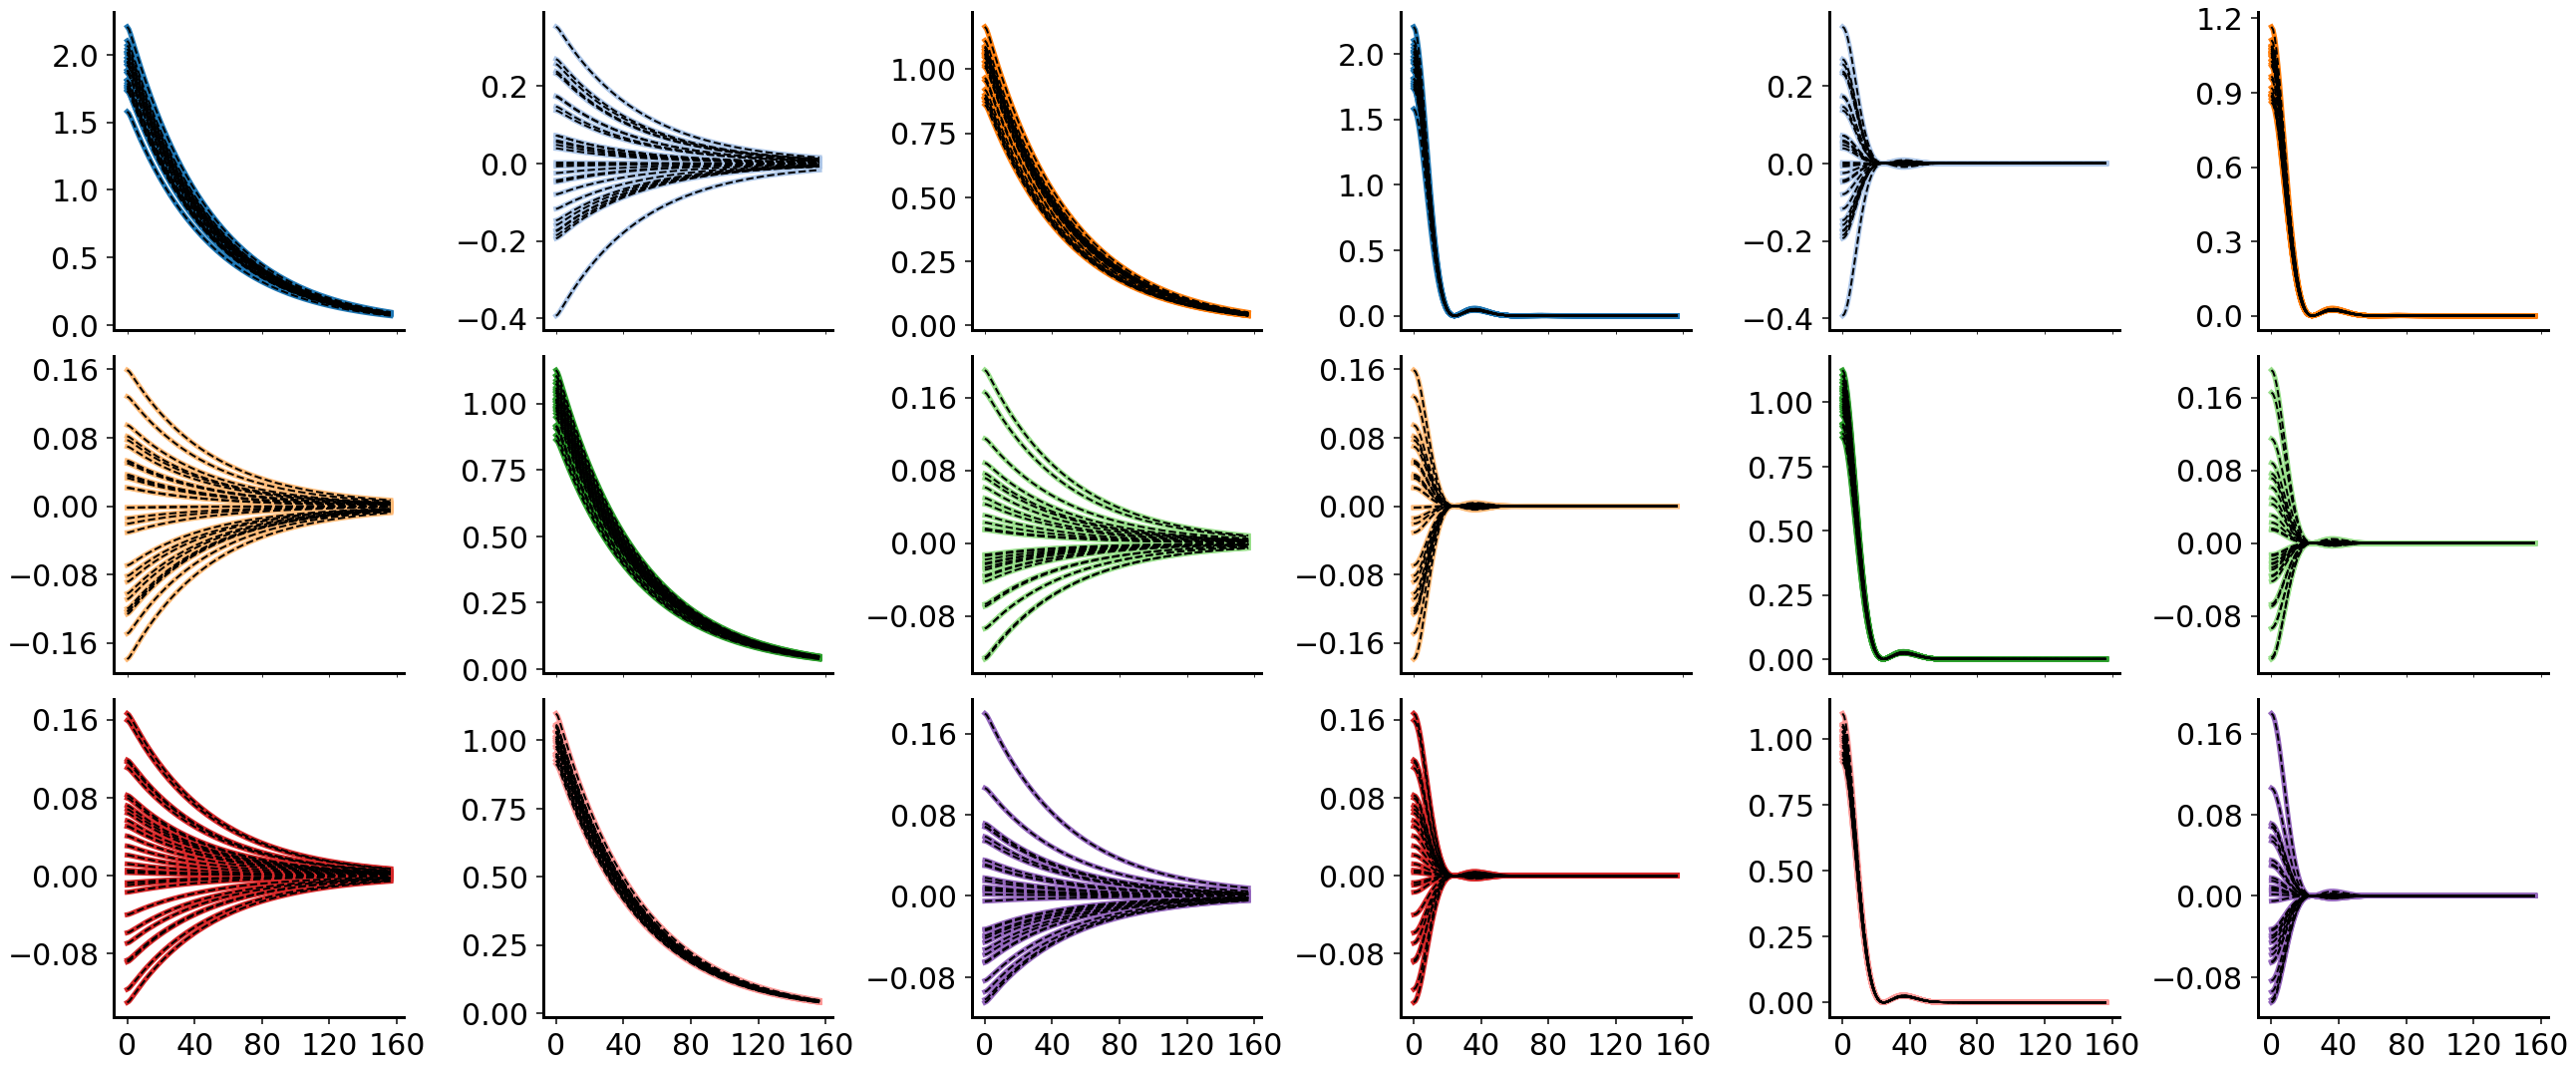

In [8]:
args = {
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "experiment": "vgg16",
    "visualization": "inversion",
}
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex='col')#, sharey='row') #sharex='col'
for i, layer in enumerate(range(9)):
    for j, beta_str in enumerate(["0.9", "0.99"]):
        lr_str = "0.01"
        wd_str = "0.01"
        gamma_str = "0"
        # plot data
        ax = axs[i//(ncols//2), i%(ncols//2) + j*nrows]
        args['expid'] = f"timnet_momentum_lr_{lr_str}_wd_{wd_str}_beta_{beta_str}_gamma_{gamma_str}"
        
        steps, empirical, theoretical = load(args)
        if steps is not None:
            steps = [lr * float(step) for step in steps]
        plot(steps, empirical, theoretical, ax, layer_wise=False, layer_list=[layer], 
             subset=30, color_idx_adj=0 if args["visualization"] == "scale" else -1, theory_color="k", **{"lw":5})


        # tick params and axis labels
        
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                       labelbottom=True, left=True, right=False,
                       labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=30)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        if i > 5:
            ax.tick_params(axis="x", which="both", bottom=True, top=False,
                           labelbottom=True, left=True, right=False,
                           labelleft=True,direction='out',length=7,width=1.5,pad=8,
                           labelsize=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
            ax.xaxis.offsetText.set_fontsize(20)
            
        # boundary
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        for dir in ["top", "bottom", "right", "left"]:
            ax.spines[dir].set_linewidth(3)
        
            
plt.tight_layout()
plt.savefig("over-under-damped-momentum-inversion.pdf")